In [1]:
import pandas as pd
import numpy as np
import bnlearn as bn
from copy import deepcopy

In [2]:
### Read data from dataset ###

trainval_df = pd.read_pickle('train.pkl').reset_index(drop=True)
print(len(trainval_df))

class_0 = trainval_df[trainval_df['label'] == 0]
class_1 = trainval_df[trainval_df['label'] == 1]
n_samples = len(class_1) 
class_0_downsampled = class_0.sample(n_samples, random_state=1)
df_balanced = pd.concat([class_0_downsampled, class_1])
train_df = df_balanced.reset_index(drop=True)


972357


In [3]:
### Processing ###

# Drop the array column
train_df = train_df.drop("X_cont", axis='columns')

# Replace missing values with median
for col in train_df.columns:
    train_df[col] = train_df[col].fillna(train_df[col].median())

print(train_df.shape)
print(train_df)

(35886, 34)
       Unit1  Gender  HospAdmTime       Age       DBP      Temp   Glucose  \
0        1.0     0.0    -0.168848  2.319899 -0.204483 -0.035927  2.070995   
1        1.0     0.0     0.341381 -0.780762  2.013551 -0.113650 -0.564311   
2        1.0     1.0    -0.539111  1.589399 -0.955752  0.417457  0.743581   
3        1.0     0.0     0.341320  0.839387  0.761435  0.210196 -0.017729   
4        0.0     1.0     0.177109 -0.606979 -0.562230 -0.230234 -0.261739   
...      ...     ...          ...       ...       ...       ...       ...   
35881    1.0     1.0     0.341320 -1.338698 -0.061384  0.806072 -0.232458   
35882    1.0     1.0     0.341320 -1.338698 -0.204483  0.806072 -0.232458   
35883    1.0     1.0     0.341320 -1.338698 -0.419131  0.806072 -0.232458   
35884    1.0     1.0     0.341320 -1.338698 -0.562230  0.806072 -0.164135   
35885    1.0     1.0     0.341320 -1.338698 -0.419131  0.806072 -0.095812   

       Potassium       Hct      FiO2  ...      SaO2       PTT  

In [4]:
### Discretize Continuous Data ###

# Get the continuous variables
cont_cols = np.array(train_df.columns).tolist()
cont_cols.remove("Unit1")
cont_cols.remove("Gender")
cont_cols.remove("label")
print(cont_cols)

train_df_discrete = deepcopy(train_df)

# Discretize each column into a given number of quantiles
n_quantiles = 4
for col in cont_cols:

    # Add arbitrarily large upper and lower bounds
    vals = np.array(train_df_discrete[col])
    vals = np.append(vals, 1e8)
    vals = np.append(vals, -1e8)

    # Discretize
    col_disc = pd.qcut(vals, n_quantiles, duplicates='drop')
    # Remove the added bounds
    col_disc = col_disc.to_list()
    col_disc.pop(-1)
    col_disc.pop(-1)

    train_df_discrete[col] = pd.Categorical(col_disc)

print(train_df_discrete)

"""
# This is bnlearn's built-in discretization method 
# However, it is too computationally expensive for large datasets

# Make arbitrary edges for discretization
edges = []
for var in cont_cols:
    edges.append(("label", var))

# Discretize continuous variables

train_df_discrete = bn.discretize(train_df, edges, cont_cols, max_iterations=1)
print(train_df_discrete)
val_discrete = bn.discretize(val, edges, cont_cols, max_iterations=1)
print(val_discrete)
"""

['HospAdmTime', 'Age', 'DBP', 'Temp', 'Glucose', 'Potassium', 'Hct', 'FiO2', 'Hgb', 'pH', 'BUN', 'WBC', 'Magnesium', 'Creatinine', 'Platelets', 'Calcium', 'PaCO2', 'BaseExcess', 'Chloride', 'HCO3', 'Phosphate', 'EtCO2', 'SaO2', 'PTT', 'Lactate', 'AST', 'Alkalinephos', 'Bilirubin_total', 'TroponinI', 'Fibrinogen', 'Bilirubin_direct']
       Unit1  Gender               HospAdmTime                       Age  \
0        1.0     0.0  (-100000000.001, 0.0192]      (0.735, 100000000.0]   
1        1.0     0.0      (0.341, 100000000.0]  (-100000000.001, -0.618]   
2        1.0     1.0  (-100000000.001, 0.0192]      (0.735, 100000000.0]   
3        1.0     0.0            (0.311, 0.341]      (0.735, 100000000.0]   
4        0.0     1.0           (0.0192, 0.311]           (-0.618, 0.125]   
...      ...     ...                       ...                       ...   
35881    1.0     1.0            (0.311, 0.341]  (-100000000.001, -0.618]   
35882    1.0     1.0            (0.311, 0.341]  (-1000000

'\n# This is bnlearn\'s built-in discretization method \n# However, it is too computationally expensive for large datasets\n\n# Make arbitrary edges for discretization\nedges = []\nfor var in cont_cols:\n    edges.append(("label", var))\n\n# Discretize continuous variables\n\ntrain_df_discrete = bn.discretize(train_df, edges, cont_cols, max_iterations=1)\nprint(train_df_discrete)\nval_discrete = bn.discretize(val, edges, cont_cols, max_iterations=1)\nprint(val_discrete)\n'

In [5]:
### Structure Learning ###

# Learn the structure
bn_model = bn.structure_learning.fit(train_df_discrete, methodtype='tan', scoretype='bic', class_node='label')

[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/561.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/561.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).


[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


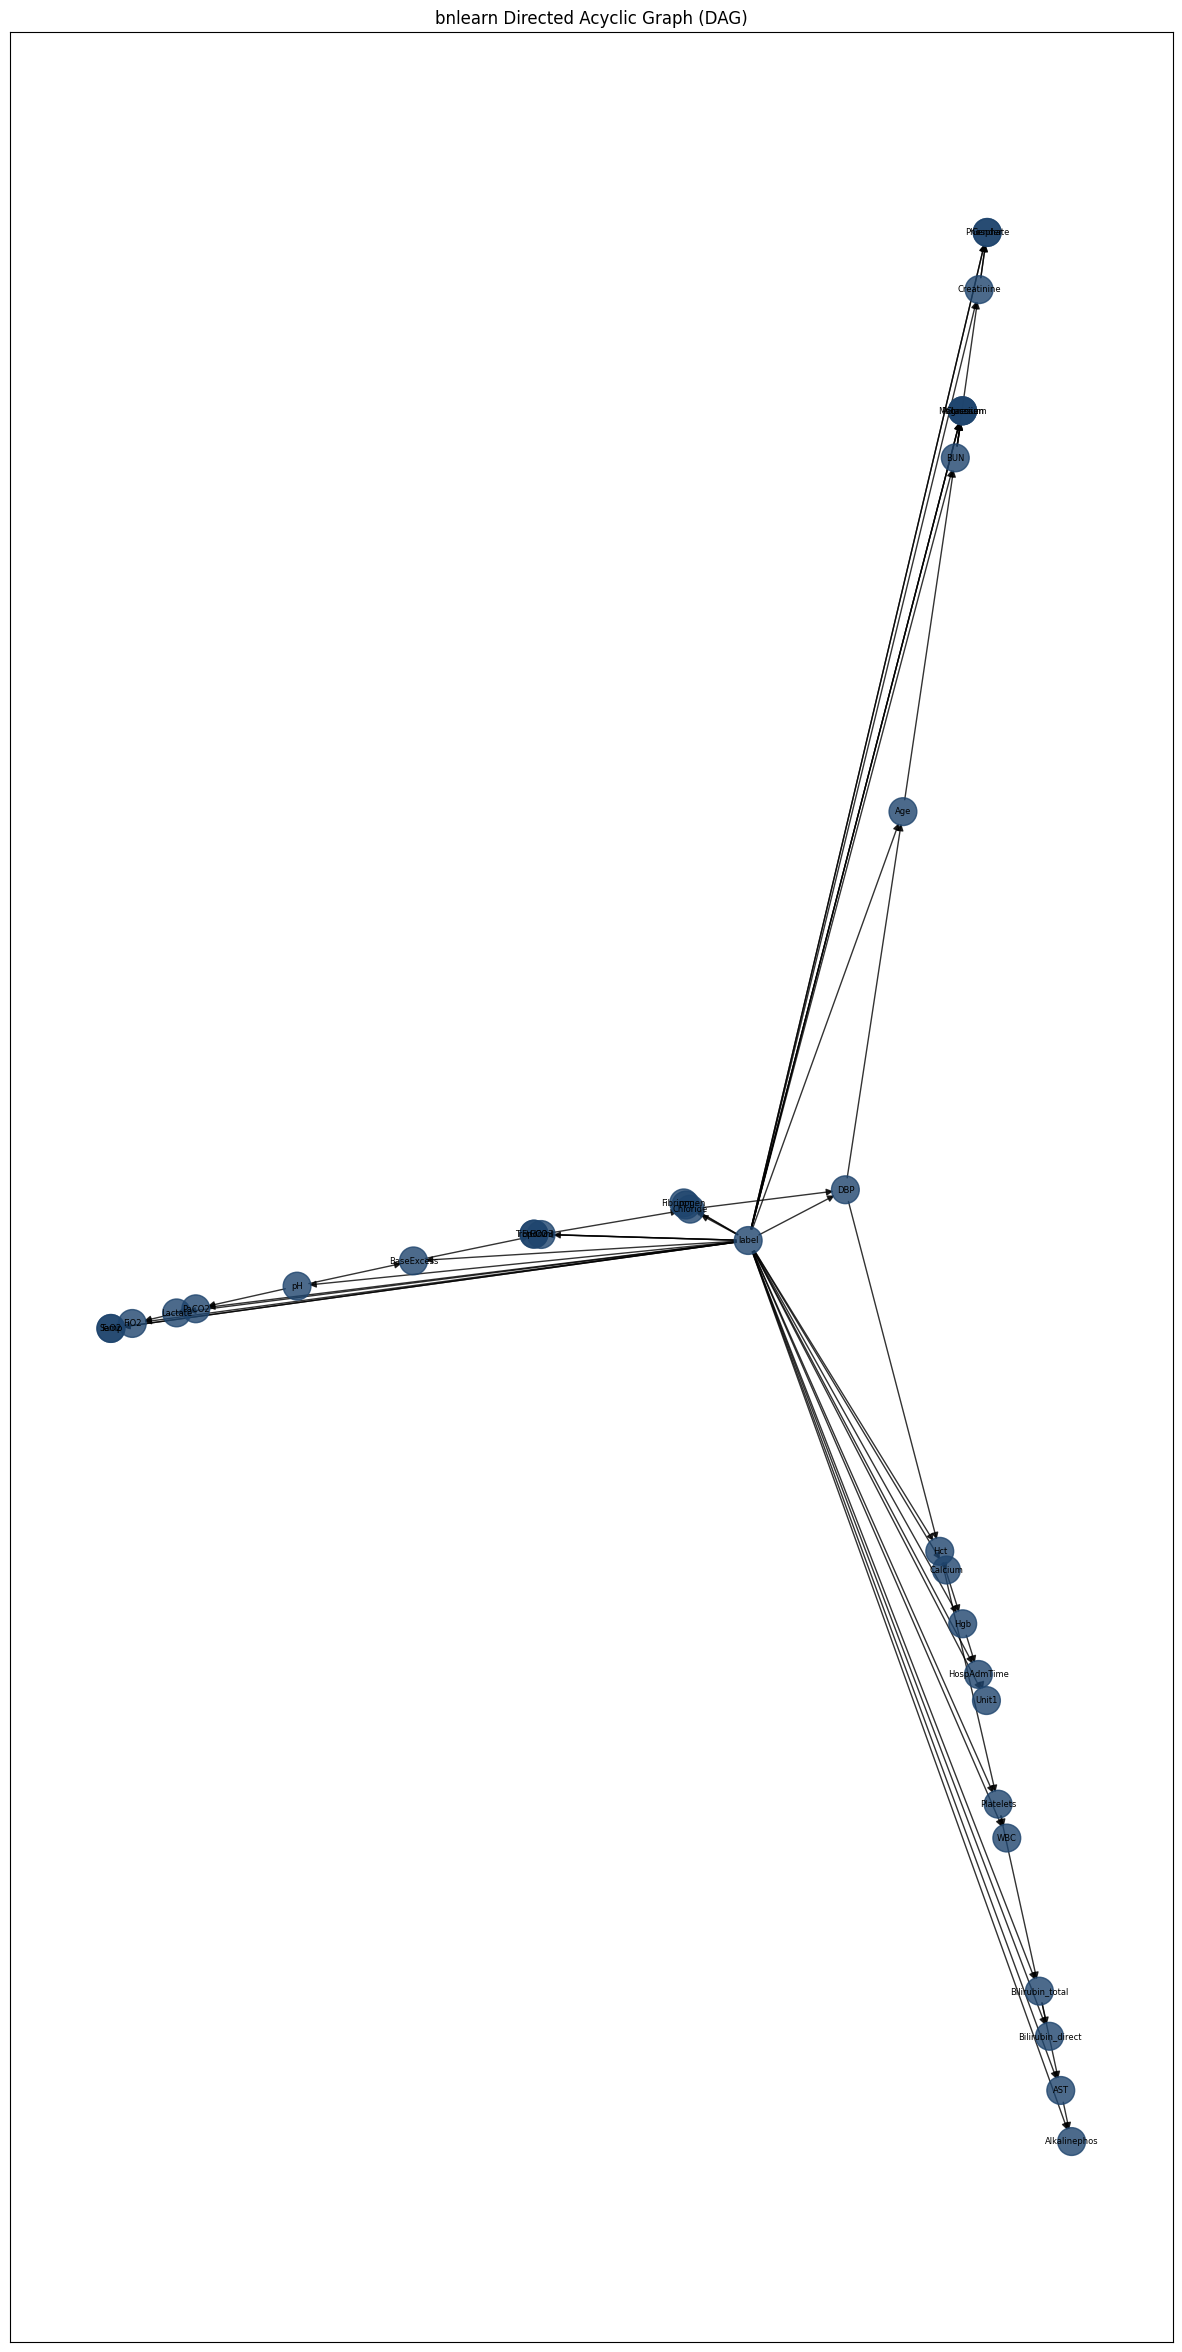

{'fig': <Figure size 1500x3000 with 1 Axes>,
 'ax': <Figure size 1500x3000 with 1 Axes>,
 'pos': {'pH': array([-0.70786539, -0.04178041]),
  'PaCO2': array([-0.86675904, -0.06252722]),
  'BaseExcess': array([-0.52519287, -0.01866433]),
  'FiO2': array([-0.96640765, -0.07596932]),
  'Lactate': array([-0.8968876 , -0.06628615]),
  'HCO3': array([-0.3248779 ,  0.00551015]),
  'SaO2': array([-1.        , -0.08053635]),
  'Temp': array([-1.        , -0.08053635]),
  'Chloride': array([-0.09106398,  0.02870967]),
  'EtCO2': array([-0.33617066,  0.00584141]),
  'TroponinI': array([-0.33617066,  0.00584141]),
  'PTT': array([-0.09774509,  0.03250732]),
  'DBP': array([0.1524901 , 0.04648348]),
  'Fibrinogen': array([-0.10114271,  0.03446155]),
  'Age': array([0.24281576, 0.39276778]),
  'Hct': array([ 0.30059602, -0.28466299]),
  'BUN': array([0.32498467, 0.71677913]),
  'Hgb': array([ 0.33659844, -0.35099612]),
  'Calcium': array([ 0.31104474, -0.301776  ]),
  'Platelets': array([ 0.39215307,

In [6]:
# Make plot
bn.plot(bn_model, node_size=400, params_static = {'width':15, 'height':30, 'font_size':6, 'alpha':0.8, 'arrowsize':10})

[bnlearn] >Compute edge strength with [chi_square]
        source            target  stat_test        p_value    chi_square  \
0           pH             PaCO2       True   0.000000e+00  4.399176e+05   
1           pH        BaseExcess       True   0.000000e+00  3.760205e+05   
2        PaCO2              FiO2       True   0.000000e+00  3.312153e+05   
3        PaCO2           Lactate       True   0.000000e+00  3.063830e+06   
4   BaseExcess              HCO3       True   0.000000e+00  2.633571e+06   
..         ...               ...        ...            ...           ...   
60       label      Alkalinephos       True  1.124563e-265  2.612276e+03   
61       label   Bilirubin_total       True  4.806800e-228  1.910405e+03   
62       label         TroponinI       True   3.950562e-90  1.851404e+03   
63       label        Fibrinogen       True  3.493119e-235  2.663065e+03   
64       label  Bilirubin_direct       True   1.799919e-97  8.994917e+02   

       dof  
0    57664  
1    33048

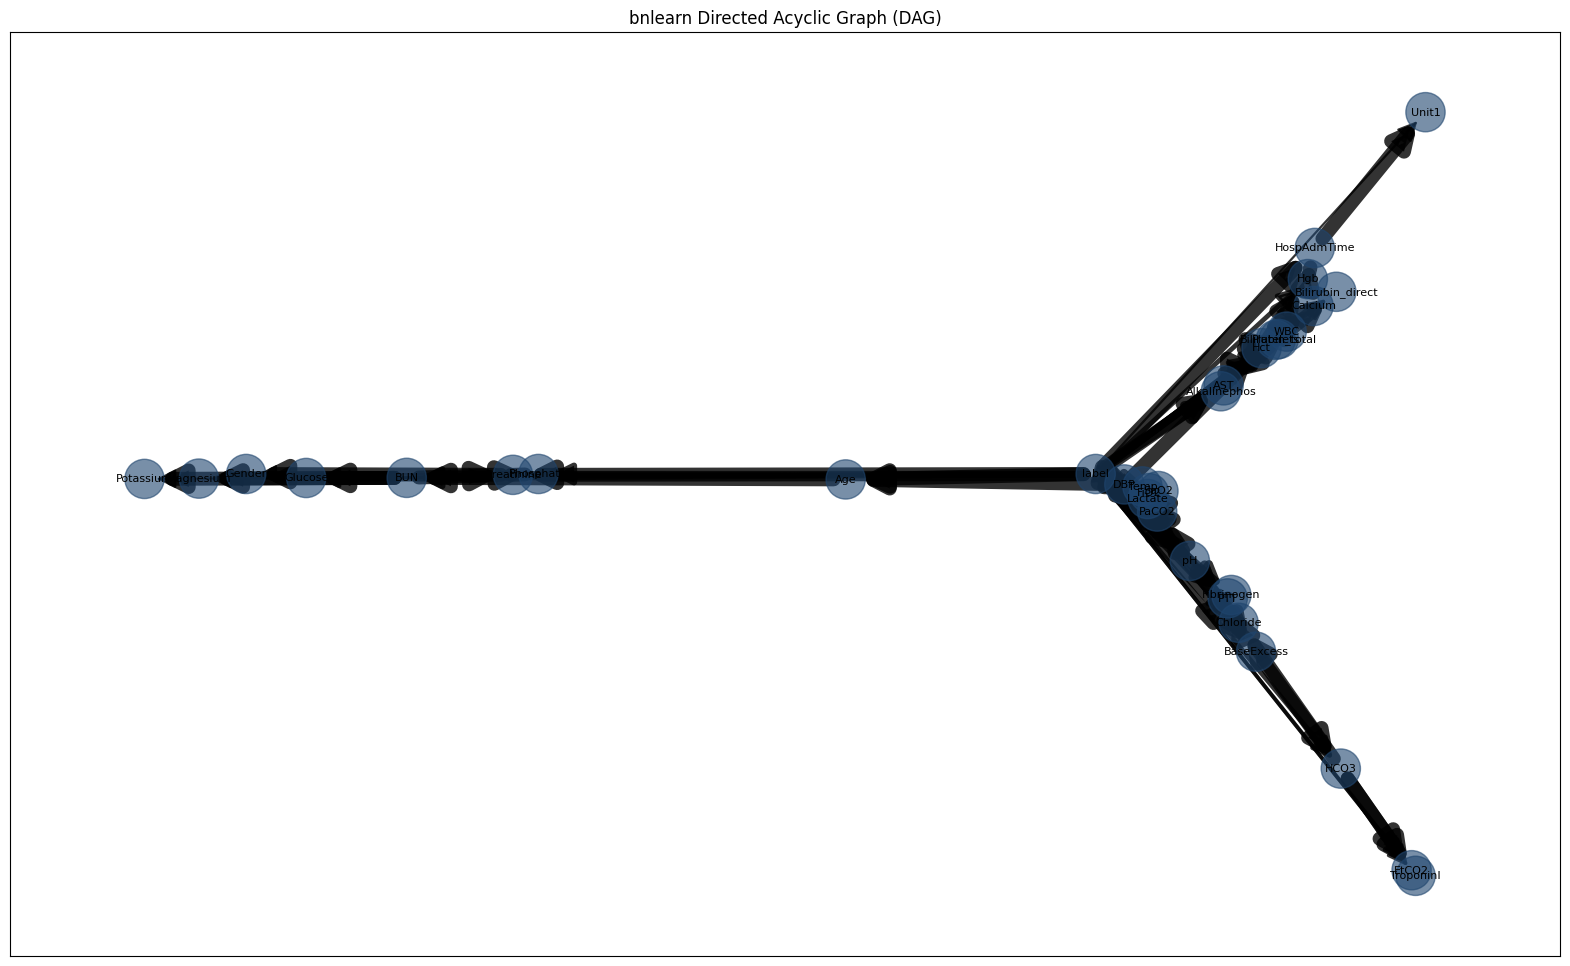

{'fig': <Figure size 2000x1200 with 1 Axes>,
 'ax': <Figure size 2000x1200 with 1 Axes>,
 'pos': {'AST': array([0.1795826 , 0.22548063]),
  'Alkalinephos': array([0.17672118, 0.21072562]),
  'Age': array([-0.21341356, -0.00956648]),
  'BUN': array([-0.66988492, -0.00559966]),
  'Creatinine': array([-0.55942677,  0.00191502]),
  'Glucose': array([-0.77444269, -0.00591333]),
  'Magnesium': array([-0.88602477, -0.00746971]),
  'Potassium': array([-0.94258219, -0.00827989]),
  'BaseExcess': array([ 0.2132773 , -0.43998948]),
  'HCO3': array([ 0.30145407, -0.73205292]),
  'Bilirubin_total': array([0.23697194, 0.34135059]),
  'Bilirubin_direct': array([0.29683721, 0.45930657]),
  'Chloride': array([ 0.19515331, -0.36774122]),
  'DBP': array([ 0.07636626, -0.02205378]),
  'PTT': array([ 0.18384906, -0.30681095]),
  'Gender': array([-0.83687838,  0.00409726]),
  'Phosphate': array([-0.53298108,  0.00408243]),
  'Hct': array([0.21900917, 0.31850728]),
  'FiO2': array([ 0.10217992, -0.04364714])

In [7]:
### Independence test ###
bn_model = bn.independence_test(bn_model, train_df, prune=True)
print(bn_model['independence_test'])
bn.plot(bn_model, params_static = {'width':20, 'height':12, 'font_size':8, 'node_size':2, 'alpha':0.6})

In [8]:
print(bn_model["adjmat"])

target               pH  PaCO2 BaseExcess   FiO2 Lactate      HCO3     SaO2  \
source                                                                        
pH                False   10.0       10.0  False   False     False    False   
PaCO2             False  False      False   10.0    10.0     False    False   
BaseExcess        False  False      False  False   False      10.0    False   
FiO2              False  False      False  False   False     False     10.0   
Lactate           False  False      False  False   False     False    False   
HCO3              False  False      False  False   False     False    False   
SaO2              False  False      False  False   False     False    False   
Temp              False  False      False  False   False     False    False   
Chloride          False  False      False  False   False     False    False   
EtCO2             False  False      False  False   False     False    False   
TroponinI         False  False      False  False   F

[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of pH:
+------------------------------+---------------------+---------------------+
| label                        | label(0)            | label(1)            |
+------------------------------+---------------------+---------------------+
| pH((-100000000.001, 0.0174]) | 0.23060239657322562 | 0.3074337146884997  |
+------------------------------+---------------------+---------------------+
| pH((0.0174, 0.285])          | 0.5275172152036003  | 0.2690451661877135  |
+------------------------------+---------------------+---------------------+
| pH((0.285, 0.553])           | 0.0750420213631188  | 0.10838800628964919 |
+------------------------------+---------------------+---------------------+
| pH((0.553, 100000000.0])     | 0.1668383668600553  | 0.31513311283413764 |
+-------------

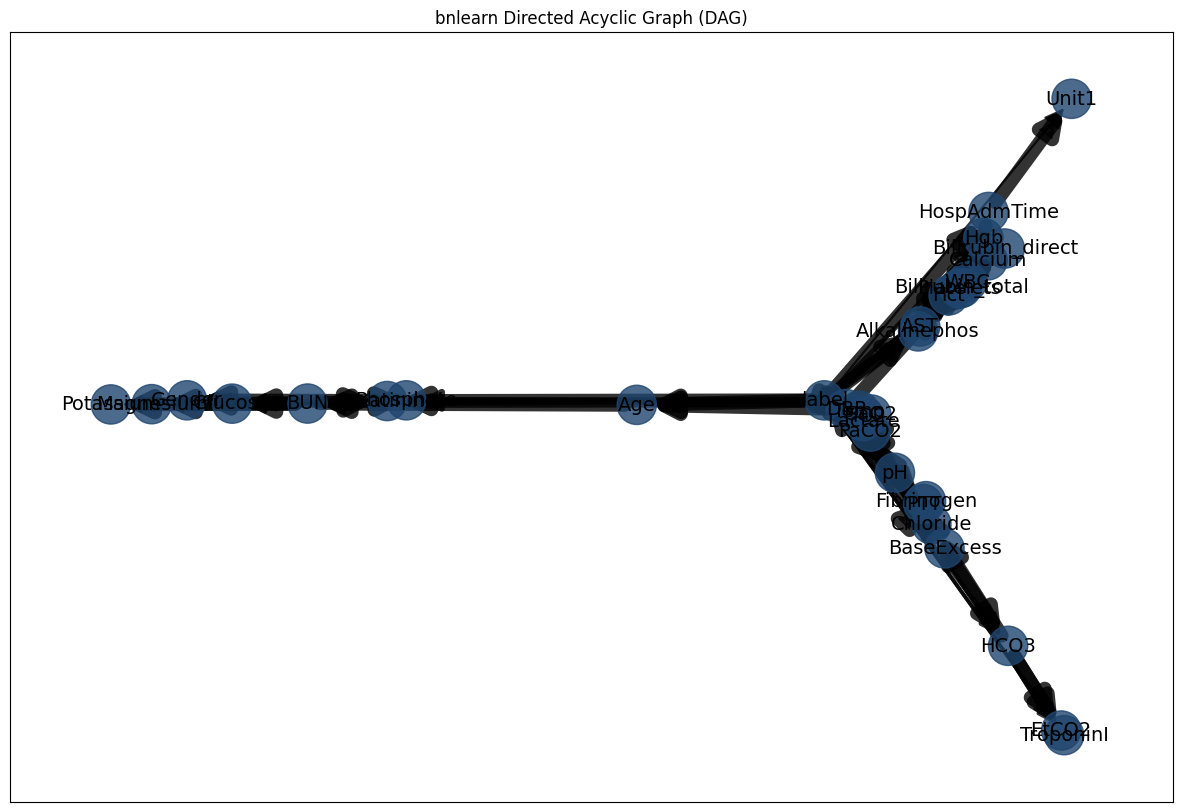

{'fig': <Figure size 1500x1000 with 1 Axes>,
 'ax': <Figure size 1500x1000 with 1 Axes>,
 'pos': {'AST': array([0.1795826 , 0.22548063]),
  'Alkalinephos': array([0.17672118, 0.21072562]),
  'Age': array([-0.21341356, -0.00956648]),
  'BUN': array([-0.66988492, -0.00559966]),
  'Creatinine': array([-0.55942677,  0.00191502]),
  'Glucose': array([-0.77444269, -0.00591333]),
  'Magnesium': array([-0.88602477, -0.00746971]),
  'Potassium': array([-0.94258219, -0.00827989]),
  'BaseExcess': array([ 0.2132773 , -0.43998948]),
  'HCO3': array([ 0.30145407, -0.73205292]),
  'Bilirubin_total': array([0.23697194, 0.34135059]),
  'Bilirubin_direct': array([0.29683721, 0.45930657]),
  'Chloride': array([ 0.19515331, -0.36774122]),
  'DBP': array([ 0.07636626, -0.02205378]),
  'PTT': array([ 0.18384906, -0.30681095]),
  'Gender': array([-0.83687838,  0.00409726]),
  'Phosphate': array([-0.53298108,  0.00408243]),
  'Hct': array([0.21900917, 0.31850728]),
  'FiO2': array([ 0.10217992, -0.04364714])

In [9]:
### Parameter Learning ###

bn_model = bn.parameter_learning.fit(bn_model, train_df_discrete)
# Independence test
bn_model = bn.independence_test(bn_model, train_df, prune=True)
# Make plot
bn.plot(bn_model)

In [10]:
print(bn_model["adjmat"])

target               pH  PaCO2 BaseExcess   FiO2 Lactate      HCO3     SaO2  \
source                                                                        
pH                False   10.0       10.0  False   False     False    False   
PaCO2             False  False      False   10.0    10.0     False    False   
BaseExcess        False  False      False  False   False      10.0    False   
FiO2              False  False      False  False   False     False     10.0   
Lactate           False  False      False  False   False     False    False   
HCO3              False  False      False  False   False     False    False   
SaO2              False  False      False  False   False     False    False   
Temp              False  False      False  False   False     False    False   
Chloride          False  False      False  False   False     False    False   
EtCO2             False  False      False  False   False     False    False   
TroponinI         False  False      False  False   F

In [11]:
#bn.print_CPD(bn_model)

[bnlearn] >Warning: variable(s) [None] does not exists in DAG.
[bnlearn] >Data is stored in [query.df]
+----+--------------------------+---------+----------+
|    | pH                       |   label |        p |
+====+==========================+=========+==========+
|  0 | (-100000000.001, 0.0174] |       0 | 0.230602 |
+----+--------------------------+---------+----------+
|  1 | (-100000000.001, 0.0174] |       1 | 0.307434 |
+----+--------------------------+---------+----------+
|  2 | (0.0174, 0.285]          |       0 | 0.527517 |
+----+--------------------------+---------+----------+
|  3 | (0.0174, 0.285]          |       1 | 0.269045 |
+----+--------------------------+---------+----------+
|  4 | (0.285, 0.553]           |       0 | 0.075042 |
+----+--------------------------+---------+----------+
|  5 | (0.285, 0.553]           |       1 | 0.108388 |
+----+--------------------------+---------+----------+
|  6 | (0.553, 100000000.0]     |       0 | 0.166838 |
+----+-----------

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f5c23af4e80>>
Traceback (most recent call last):
  File "/home/jren/miniconda3/envs/cog_ai/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


[bnlearn] >No CPDs to print. Hint: Add CPDs as following: <bn.make_DAG(DAG, CPD=[cpd_A, cpd_B, etc])> and use bnlearn.plot(DAG) to make a plot.


{'pH':                          pH  label         p
 0  (-100000000.001, 0.0174]      0  0.230602
 1  (-100000000.001, 0.0174]      1  0.307434
 2           (0.0174, 0.285]      0  0.527517
 3           (0.0174, 0.285]      1  0.269045
 4            (0.285, 0.553]      0  0.075042
 5            (0.285, 0.553]      1  0.108388
 6      (0.553, 100000000.0]      0  0.166838
 7      (0.553, 100000000.0]      1  0.315133,
 'PaCO2':                        PaCO2  label                        pH         p
 0   (-100000000.001, -0.431]      0  (-100000000.001, 0.0174]  0.224606
 1   (-100000000.001, -0.431]      0           (0.0174, 0.285]  0.044943
 2   (-100000000.001, -0.431]      0            (0.285, 0.553]  0.354227
 3   (-100000000.001, -0.431]      0      (0.553, 100000000.0]  0.550292
 4   (-100000000.001, -0.431]      1  (-100000000.001, 0.0174]  0.240256
 5   (-100000000.001, -0.431]      1           (0.0174, 0.285]  0.104041
 6   (-100000000.001, -0.431]      1            (0.285, 0.5

In [12]:
# Read test dataset
test_df = pd.read_pickle('test.pkl').reset_index(drop=True)
test_df = test_df.drop("X_cont", axis="columns")

# Replace missing values with median
for col in test_df.columns:
    test_df[col] = test_df[col].fillna(test_df[col].median())

print(len(test_df))
print(test_df)

166921
        Unit1  Gender  HospAdmTime       Age       DBP      Temp   Glucose  \
0         0.0     0.0     0.220580  0.096692 -0.168708 -0.696572  0.001792   
1         0.0     0.0     0.220580  0.096692 -0.240257 -0.657711  0.001792   
2         0.0     0.0     0.220580  0.096692 -0.240257 -0.618849  0.001792   
3         0.0     0.0     0.220580  0.096692 -0.276032 -0.618849  0.001792   
4         0.0     0.0     0.220580  0.096692 -0.240257 -0.618849  0.001792   
...       ...     ...          ...       ...       ...       ...       ...   
166916    0.0     0.0     0.340897 -0.667955  1.655804 -0.100696  0.148197   
166917    0.0     0.0     0.340897 -0.667955  1.655804 -0.100696 -0.095812   
166918    0.0     0.0     0.340897 -0.667955  1.655804 -0.100696 -0.095812   
166919    0.0     0.0     0.340897 -0.667955  1.620029 -0.100696 -0.095812   
166920    0.0     0.0     0.340897 -0.667955  1.620029  0.093611 -0.242218   

        Potassium       Hct      FiO2  ...      SaO2    

In [13]:
# Discretize test dataset based on train dataset bins

for col in cont_cols:
    print(col)
    for i in range(len(test_df)):
        val = test_df[col].iloc[i]
        val_disc = bn.discretize_value(train_df_discrete[col], val)
        test_df[col].iloc[i] = val_disc

print(test_df)

HospAdmTime
Age
DBP
Temp
Glucose
Potassium
Hct
FiO2
Hgb
pH
BUN
WBC
Magnesium
Creatinine
Platelets
Calcium
PaCO2
BaseExcess
Chloride
HCO3
Phosphate
EtCO2
SaO2
PTT
Lactate
AST
Alkalinephos
Bilirubin_total
TroponinI
Fibrinogen
Bilirubin_direct
        Unit1  Gender      HospAdmTime                       Age  \
0         0.0     0.0  (0.0192, 0.311]           (-0.618, 0.125]   
1         0.0     0.0  (0.0192, 0.311]           (-0.618, 0.125]   
2         0.0     0.0  (0.0192, 0.311]           (-0.618, 0.125]   
3         0.0     0.0  (0.0192, 0.311]           (-0.618, 0.125]   
4         0.0     0.0  (0.0192, 0.311]           (-0.618, 0.125]   
...       ...     ...              ...                       ...   
166916    0.0     0.0   (0.311, 0.341]  (-100000000.001, -0.618]   
166917    0.0     0.0   (0.311, 0.341]  (-100000000.001, -0.618]   
166918    0.0     0.0   (0.311, 0.341]  (-100000000.001, -0.618]   
166919    0.0     0.0   (0.311, 0.341]  (-100000000.001, -0.618]   
166920    0

In [14]:
### Predict ###

import bnlearn as bn

# Remove columns not included in the graph
test_df_final = deepcopy(test_df)
for col in test_df_final.columns:
    col_in_graph = False
    if col == 'label':
        continue
    for edge in bn_model["model_edges"]:
        if edge[0] == col or edge[1] == col:
            col_in_graph = True
            break
    if not col_in_graph:
        test_df_final = test_df_final.drop(col, axis='columns')

pred = bn.predict(bn_model, test_df_final, variables=['label'])
print(pred)

[bnlearn]> Remaining columns for inference: 33


 22%|██▏       | 10052/46461 [2:18:49<8:22:50,  1.21it/s] 


KeyboardInterrupt: 